
# Criando um modelo para identificação e detecção de placas de trânsito americanas



## Dataset utilizado


O dataset é o [Self-Driving Cars Computer Vision Project](https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/2) disponibilizado no site Roboflow.

A base de dados específica utilizada é a [versão 2](https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/2) a qual foi gerada em vinte e quatro de fevereiro de 2023 e conta com 4477 imagens, já divididas em treino (3129 imagens ou 70% do conjunto), validação (758 ou 17%) e teste (590 ou 13%). Além disso, todas as imagens são pré-processadas para que fiquem com tamanho de 416x416 pixels e não é realizado nenhum tipo de data augmentation.

![Imagem mostrando os dados descritos no texto acima](./assets/dataset_details.jpg)




## Análise dos dados


### Distribuição das classes


No site do Roboflow é possível ver a distribuição das classes do dataset, no entanto esses dados são a respeito do último dataset criado, o que no momento da criação desse notebook é a versão 4 - Prescan- 416x416, portanto pode-se usar essa informação para ter uma boa noção da distribuição dos dados, mas ela não os representa fielmente.

![Aproximação da distribuição das classes do dataset](./assets/dataset_balance.jpg)

Por conta disso, vamos importar os dados no formato COCO JSON para realizar a análise dos dados e obter as respostas de maneira mais precisa.

In [ ]:
# Faz o download do dataset no formato COCO JSON
! curl -L "https://universe.roboflow.com/ds/DyOxa06LLg?key=8NgMspeEod" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [84]:
# Importa todas as bibliotecas necessárias
import json
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
def plot_classes_distribution(path, title, ax):
    """Plots the classes distribution from a single COCO JSON file using matplotlib

    Args:
        path (str): the relative path to the COCO file
        title (str): the title of the plot
        ax (matplotlib.axes.Axes): the Axes object to plot the distribution
    """

    with open(path) as f:
        data = json.load(f)

        classes = {dict['id']: dict['name'] for dict in data['categories']}
        classes_count = {dict['id']: 0 for dict in data['categories']}

        for annotation in data['annotations']:
            classes_count[annotation['category_id']] += 1

    num_classes = len(classes)
    classes_list = [None] * num_classes
    classes_count_list = [None] * num_classes
    
    for id, category in classes_count.items():
        classes_list[id] = classes[id]
        classes_count_list[id] = category

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    ax.bar(classes_list, classes_count_list)

Gráficos mostrando as reais distribuições das classes nos conjuntos de treino, validação e teste

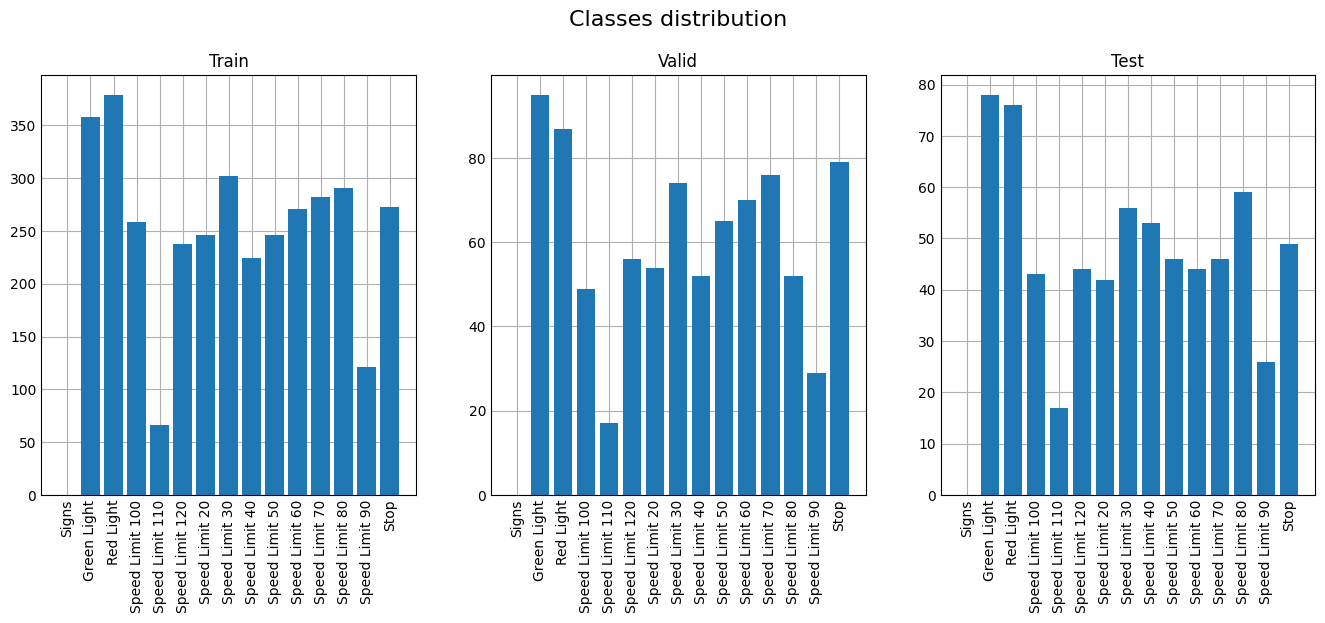

In [189]:
fig, (train, valid, test) = plt.subplots(1, 3, figsize=(13, 5))
fig.suptitle('Classes distribution', fontsize=16)
fig.subplots_adjust(top=0.85)
plot_classes_distribution('./train/_annotations.coco.json', 'Train', train)
plot_classes_distribution('./valid/_annotations.coco.json', 'Valid', valid)
plot_classes_distribution('./test/_annotations.coco.json', 'Test', test)
plt.show()

Após analisar os gráficos podemos tirar as seguintes conclusões:

- O primeiro ponto importante a se observar é que nenhuma imagem pertence à classe 'Signs' e olhando no site do Roboflow percebe-se que ela não é considerada como uma classe, mas ela só aparece por conta do formato COCO JSON que foi utilizado. Além disso, no nosso dataset temos 14 classes, o que é diferente das 15 que são apresentadas no site do Roboflow, já que como citado acima os dados utilizados são mais antigo e não apresentam a clase 'Speed limit 10'.

- Vendo os gráficos percebemos que a distribuição das classes é muito semelhante nos três conjuntos de dados, treino, teste e validação

- Por fim vemos que os dados possuem uma distribuição relativamente balanceada, já que apenas duas classes das 14, 'Speed limit 110' e 'Speed limit 90', possuem poucas instâncias e apenas outras duas classes, 'Green Light' e 'Red Light', possuem muito mais instâncias do que o resto. Porém, as demais classes apresentam uma distribuição bem parecida com números bem representativos de exemplos.

In [191]:
# Apos plotar os graficos podemos excluir os diretorios
! rm -r test train valid README.dataset.txt README.roboflow.txt

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'valid': No such file or directory



### Tamanhos reais das imagens


Como todas as imagens são pré-processadas para terem tamanho de 416x416 pixels, a única maneira de analisar o seu tamanho original é através da plataforma do Roboflow, a qual não terá informações da maneira mais precisa como já explicado acima.

![Distribuição do tamanho original das imagens utilizadas](./assets/images_dimensions.jpg)

E vendo os dados percebemos que grande parte das imagens são muito pequenas, com dimensões menores do que 100x100 e outra grande parte possui dimensões próximas as utilizadas (416x416). Já as demais imagens, que representam uma pequena porção do total, acabam sendo ou muito maiores do que 416x416 ou estão no intervalo de dimensão entre 100x100 e 416x416


### Explorando exemplos dos dados


In [ ]:
# Fazer o download dos dados no formato que sera utilizado YOLOv8
! curl -L "https://universe.roboflow.com/ds/s5tubfUJUz?key=dAIVR4GASb" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Analisando as imagens percebemos detalhes importantes a respeito do dataset:

#### Qualidade das imagens

É possível observar uma grande diferença na qualidade das imagens:

- Por conta de muitas imagens terem uma dimensão original muito pequena, menores do que 100x100, após serem convertidas para o tamanho 416x416 muitas se tornam bem difíceis de serem identificadas, pois a imagem não fica nada nítida e outras ficam até não identificáveis e, nesse caso específico, mesmo que o modelo acerte a sua classificação esse acerto não é muito relevante:

<figure align='center'>
    <img src='./train/images/00000_00000_00009_png.rf.f73b6f96b5f14b7dba2d681438dbbb49.jpg', alt='Imagem de uma placa do conjunto de treino'>
    <figcaption>Imagem de uma placa do conjunto de treino que pode ser identificada, mas apresenta uma qualidade ruim</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/00005_00044_00012_png.rf.ffd1696047556cc62fd8387412bd0f80.jpg', alt='Imagem de uma placa do conjunto de validação'>
    <figcaption>Imagem de uma placa do conjunto de validação que pode ser identificada, mas apresenta uma qualidade ruim</figcaption>
</figure>

<figure align='center'>
    <img src='./train/images/00000_00002_00001_png.rf.1d6700dcad13058bae3ce01d1a0d54b2.jpg', alt='Imagem de uma placa do conjunto de treino que não pode ser identificada com certeza'>
    <figcaption>Imagem de uma placa do conjunto de treino que não pode ser identificada com certeza</figcaption>
</figure>

<figure align='center'>
    <img src='valid/images/00004_00040_00006_png.rf.bc5ee6eaf51862f725858ff1dfb917ba.jpg', alt='Imagem de uma placa do conjunto de validação que não pode ser identificada com certeza'>
    <figcaption>Imagem de uma placa do conjunto de validação que não pode ser identificada com certeza</figcaption>
</figure>

- Por outro lado, uma grande parte das imagens apresenta uma dimensão próxima de 416x416, o que faz com que elas apresentem uma boa qualidade e nitidez após serem convertidas:

<figure align='center'>
    <img src='./train/images/000555_jpg.rf.1c9edf25388b99091a6f0ed59fccd3b9.jpg', alt='Imagem de boa qualidade de uma placa do conjunto de treino'>
    <figcaption>Imagem de boa qualidade de uma placa do conjunto de treino</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/000716_jpg.rf.267ab7a9c55edd6befb52e89bc3c2ff3.jpg', alt='Imagem de boa qualidade uma placa do conjunto de validação'>
    <figcaption>Imagem de boa qualidade de uma placa do conjunto de validação</figcaption>
</figure>

- Além disso, existe uma pequena proporção de imagens que possuem dimensões muito maiores do que 416x416 o que faz com que quando elas sejam convertidas aconteça o mesmo que com as imagens muito pequenas, ou seja, elas se tornam muito difíceis de serem identificadas e algumas até mesmo impossíveis e, nesse caso, o acerto do modelo na classificação não é algo relevante.

<figure align='center'>
    <img src='./train/images/FisheyeCamera_1_00379_png.rf.2cbb09469a5ff572ed122d46ef81664a.jpg', alt='Imagem de uma câmera fisheye retirada do conjunto de treino'>
    <figcaption>Imagem de uma câmera fisheye retirada do conjunto de treino em que alguns objetos se tornaram muito difíceis de se identificarem e outros até impossíveis</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/FisheyeCamera_1_00605_png.rf.5e2b7334c87652d94634ca8188ee5def.jpg', alt='Imagem de uma câmera fisheye retirada do conjunto de validação'>
    <figcaption>Imagem de uma câmera fisheye retirada do conjunto de validação, é possível notar que os objetos presentes não podem ser identificados com clareza</figcaption>
</figure>

#### Tipos de imagens

Além das diversas qualidades temos basicamente três principais diferentes tipos de imagens:

- Imagens que apresentam os objetos detectáveis, placas ou semáforos, de maneira focada e normalmente centralizados, como mostrados acima

- Imagens tiradas por uma câmera fisheye o que faz com que ocorra uma distorção da imagem em comparação com o mundo real e também não mostra somente o objeto focalizado, mostra todo o ambiente em que ele se encontra, ou seja, o objeto está em segundo plano, como mostrado também nas imagens acima

- Imagens tiradas por uma câmera normal, mas no mesmo estilo das da fisheye, o que quer dizer que não apresenta os objetos focalizados e, portanto, são as que representam de maneira mais próxima a visão de um motorista. Como mostradas abaixo:

<figure align='center'>
    <img src='./train/images/road240_png.rf.504043977b032e6f89b7a3bb07e96df6.jpg', alt='Imagem retirada do conjunto de treino em que os objetos não estão focalizados'>
    <figcaption>Imagem parecida com a da câmera fisheye em que os objetos não estão sendo focalizados e é mostrado todo o ambiente como um todo, ela pertence ao conjunto de treino</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/road191_png.rf.642157f2a10d833f3eed44a8ea17ad6d.jpg', alt='Imagem retirada do conjunto de validação em que os objetos não estão focalizados'>
    <figcaption>Imagem com a mesma ideia da anterior, porém retirada do conjunto de validação</figcaption>
</figure>

#### Diversidade de imagens

Percebe-se também que por mais que o dataset seja relativamente grande ele não apresenta tanta diversidade de imagens, pois é possível notar que muitas são muito semelhantes entre si e parecem ser apenas diferentes augmentations que foram realizadas em uma única imagem original, como podemos observar abaixo:

<figure align='center'>
    <img src='./train/images/00000_00000_00000_png.rf.6aaf9596acc4d708f678ab796d5f9fe2.jpg', alt='Imagem retirada do conjunto de treino'>
    <figcaption>Imagem retirada do conjunto de treino</figcaption>
</figure>

<figure align='center'>
    <img src='./train/images/00000_00000_00001_png.rf.23fb32dd0436a6b7b695dc06e2f23eeb.jpg', alt='Imagem retirada do conjunto de treino'>
    <figcaption>Imagem retirada do conjunto de treino</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/00000_00000_00002_png.rf.22e4fd87d3bd79d0574e1add5f697056.jpg', alt='Imagem retirada do conjunto de validação'>
    <figcaption>Imagem retirada do conjunto de validação</figcaption>
</figure>

<figure align='center'>
    <img src='./valid/images/00000_00000_00011_png.rf.36812e8c55cf239680daeedd1236e4a8.jpg', alt='Imagem retirada do conjunto de validação'>
    <figcaption>Imagem retirada do conjunto de validação</figcaption>
</figure>

## Criação dos primeiros modelos

Para esse projeto foi utilizado o modelo da ultralytics YOLOv8 cuja documentação pode ser acessada [aqui](https://docs.ultralytics.com/) junto da técnica de transfer learning.

Inicialmente foram criados três modelos diferentes e cada um foi treinado por 30 epochs

In [ ]:
# anotacoes, recall parece ser mais importante do que precision, ja que algumas imagens nao tem todos os objetos anotados, entao o modelo
# identifica corretamente, mas na base de dados nao existe, alem disso algumas imagens sao bem ruins, ja q elas sao pequenas e passam por 
# um processo de serem aumentadas

In [ ]:
model = YOLO('yolov8n.pt') # import pre-trained model for object detection

DATA_PATH = './data.yaml'
IMGSZ = 416

# hyperparameters for tuning
BATCH = 8 # the best size for my GPU
EPOCHS = 30

results = model.train(
    data = DATA_PATH,
    epochs = EPOCHS,
    batch = BATCH,
    imgsz = IMGSZ,
    device = 0
)

In [25]:
train_df = pd.read_csv('./models/train/results.csv')
train2_df = pd.read_csv('./models/train2/results.csv')
train3_df = pd.read_csv('./models/train3/results.csv')

df_cols = train_df.columns
metrics = [df_cols[0], df_cols[4], df_cols[5], df_cols[6], df_cols[7]]

print('train metrics')
display(train_df[metrics].tail(1))

print('train2 metrics')
display(train2_df[metrics].tail(1))

print('train3 metrics')
display(train3_df[metrics].tail(1))

train metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.96709,0.88758,0.94636,0.8347


train2 metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.95526,0.90608,0.95416,0.83461


train3 metrics


,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
29,30,0.96623,0.899,0.95137,0.83156
